In [1]:
# from torchsr.datasets import Div2K
# from torchsr.models import ninasr_b0
from utils.training_utils import BabySINE, ImageDataset, pixel_coordinates_normalized, plot_image, list_png_files, load_image
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch
import os
import itertools
import matplotlib.pyplot as plt

# Autoreload
%reload_ext autoreload
%autoreload 2

# Div2K dataset
# dataset = Div2K(root="./data", scale=2, download=False)

In [2]:
# List all PNG files in the data folder
data_folder = "data"
image_files = list_png_files(data_folder)
print(f"Available PNG files: {image_files}")

Available PNG files: ['0010.png', '0028.png', '0002.png']


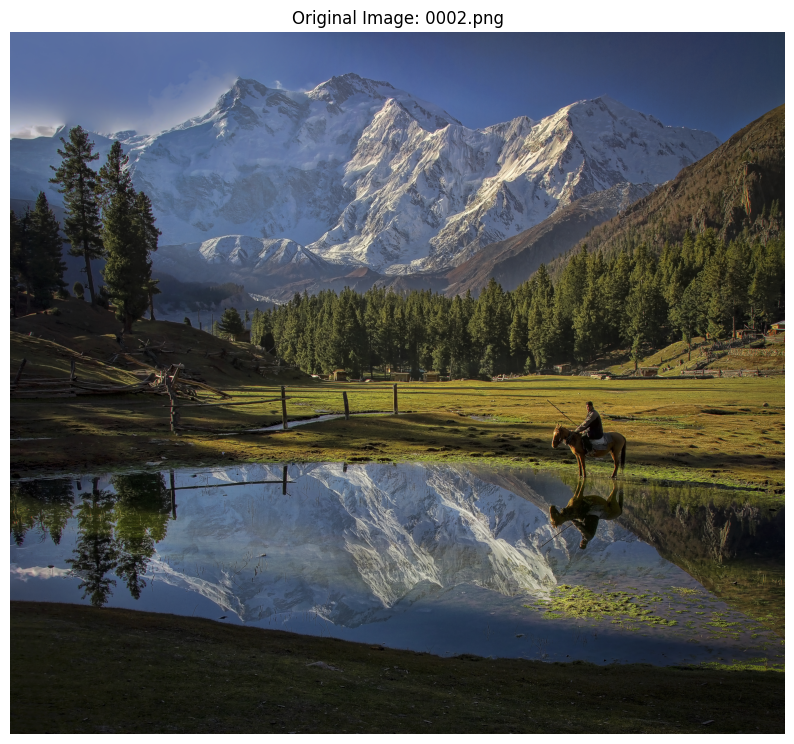

Image dimensions: 1848x2040, 3 channels


In [3]:
img_file_path = image_files[-1]
img_np_original, height_target, width_target, channels = load_image(data_folder, img_file_path)

The original image has shape: (1848, 2040, 3)
The downsampled image has shape: (528, 582, 3)


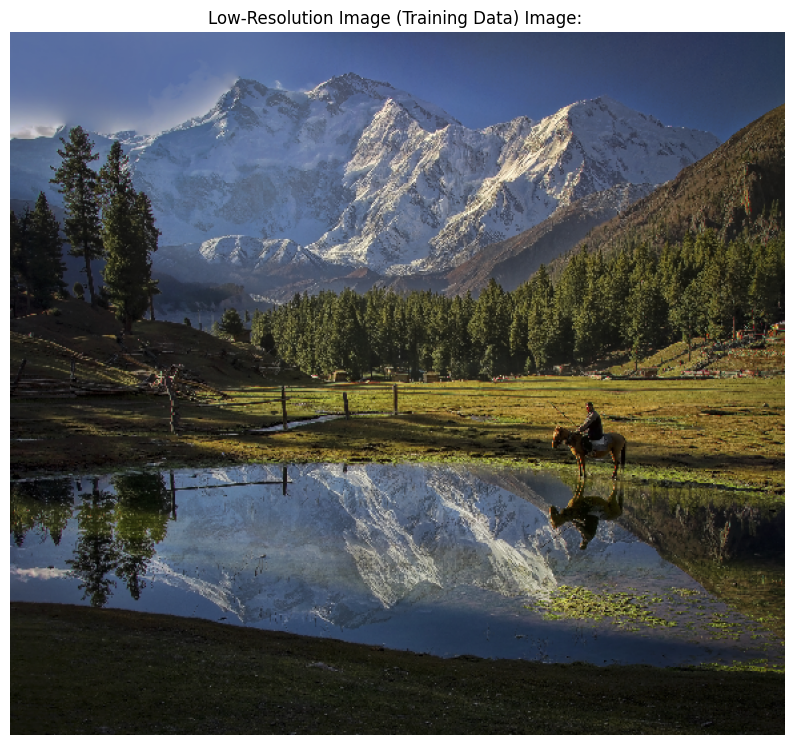

Image dimensions: 528x582, 3 channels


In [4]:
# Downsample the image and generate coordinates and pixel values
downsize_factor = 3.5 # Now we can use non-integer downsize factors
(
    low_res_coords, 
    low_res_pixel_values, 
    high_res_coords, 
    high_res_pixel_values, 
    low_res_shape, 
    high_res_shape
) = pixel_coordinates_normalized(img_np_original, downsize_factor)

# Reshape the low-resolution pixel values to the image shape
low_res_image = low_res_pixel_values.reshape(low_res_shape[0], low_res_shape[1], 3)

# Plot the low-resolution image
plot_image(low_res_image, "Low-Resolution Image (Training Data)")

In [5]:
# max and min of low_res_pixel_values
print("Low res pixel values max:", low_res_pixel_values.max())
print("Low res pixel values min:", low_res_pixel_values.min())

Low res pixel values max: 1.0
Low res pixel values min: 0.0


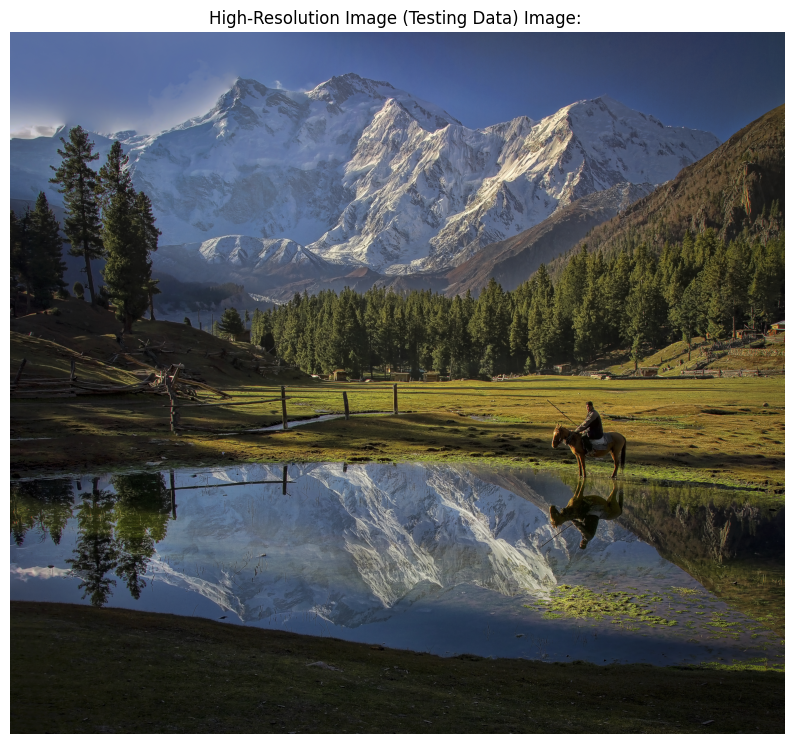

Image dimensions: 1848x2040, 3 channels


In [6]:
# Plot the original high res image

high_res_image = high_res_pixel_values.reshape(high_res_shape[0], high_res_shape[1], 3)
plot_image(high_res_image, "High-Resolution Image (Testing Data)")

In [7]:
# Create dataset and dataloader
dataset = ImageDataset(low_res_coords, low_res_pixel_values)
dataloader = DataLoader(dataset, batch_size=4096, shuffle=True)

In [8]:
# Initialize the model
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = BabySINE(sigma=10.0, omega_0=15, num_layers=4, hidden_dim = 512).to(device)

In [9]:
# Train the model
losses, scheduler_values = model.train_model(
    dataloader,
    num_epochs=200,
    lr=1e-4,
    sigma=10.0,
)

Using device: mps


  0%|          | 1/200 [00:01<05:35,  1.69s/it]

Learning rate: 0.0001
Epoch 0, Loss: 0.182327
Epoch 0: Predicted pixel values range: 0.10214263945817947, 0.7794873714447021


 25%|██▌       | 50/200 [00:54<02:42,  1.09s/it]

Learning rate: 5e-05


 50%|█████     | 100/200 [01:51<01:50,  1.11s/it]

Learning rate: 2.5e-05


 50%|█████     | 101/200 [01:52<01:49,  1.11s/it]

Epoch 100, Loss: 0.024487
Epoch 100: Predicted pixel values range: 0.034819986671209335, 0.860714852809906


 75%|███████▌  | 150/200 [02:47<00:56,  1.14s/it]

Learning rate: 1.25e-05


100%|██████████| 200/200 [03:44<00:00,  1.12s/it]

Learning rate: 6.25e-06


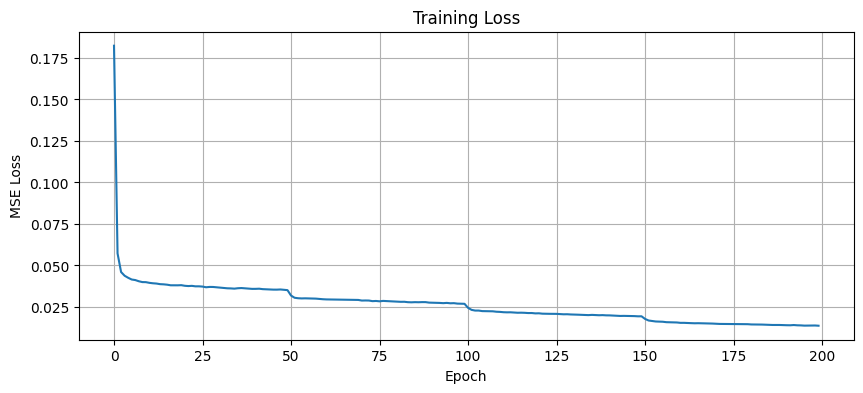

In [10]:
# Plot the loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

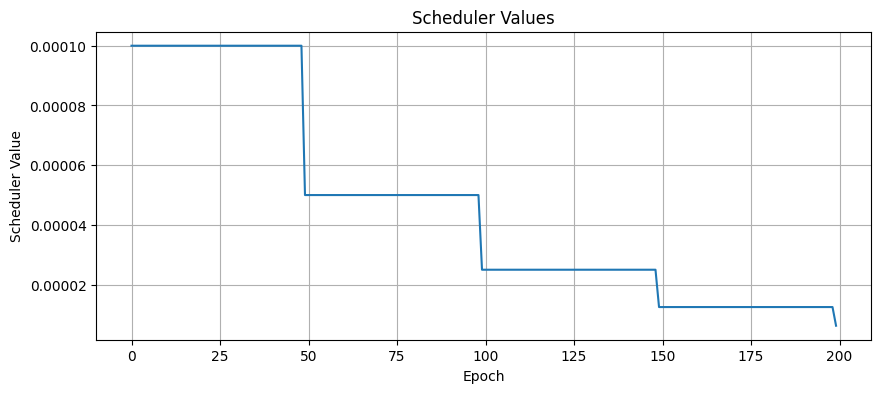

In [11]:
# Plot the scheduler values
plt.figure(figsize=(10, 4))
plt.plot(scheduler_values)
plt.title("Scheduler Values")
plt.xlabel("Epoch")
plt.ylabel("Scheduler Value")
plt.grid(True)
plt.show()

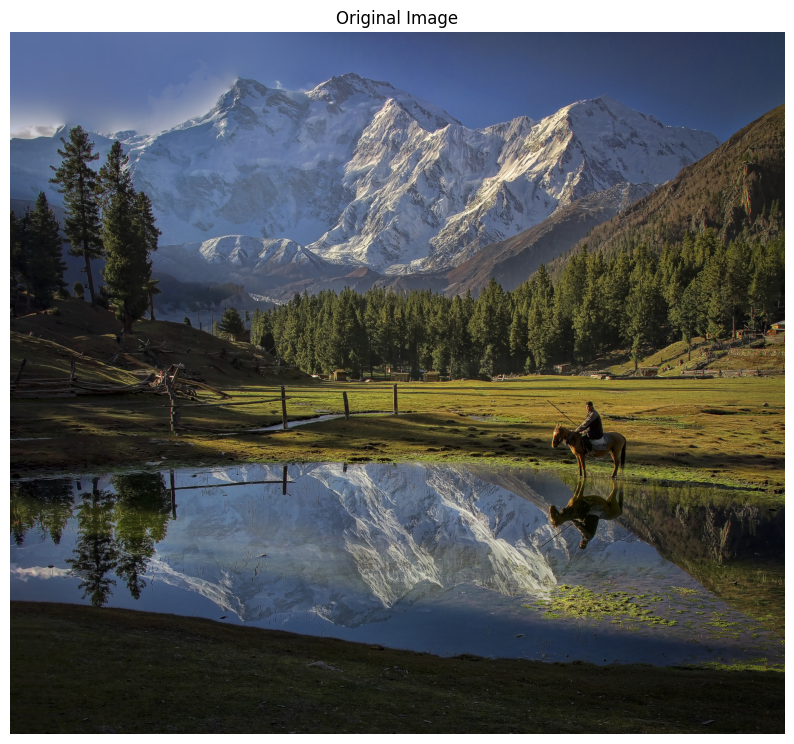

Image shape: (1848, 2040, 3)


In [12]:
# Plot the original Image
plt.figure(figsize=(10, 10))
plt.imshow(img_np_original)
plt.title("Original Image")
plt.axis("off")
plt.show()
print(f"Image shape: {img_np_original.shape}")

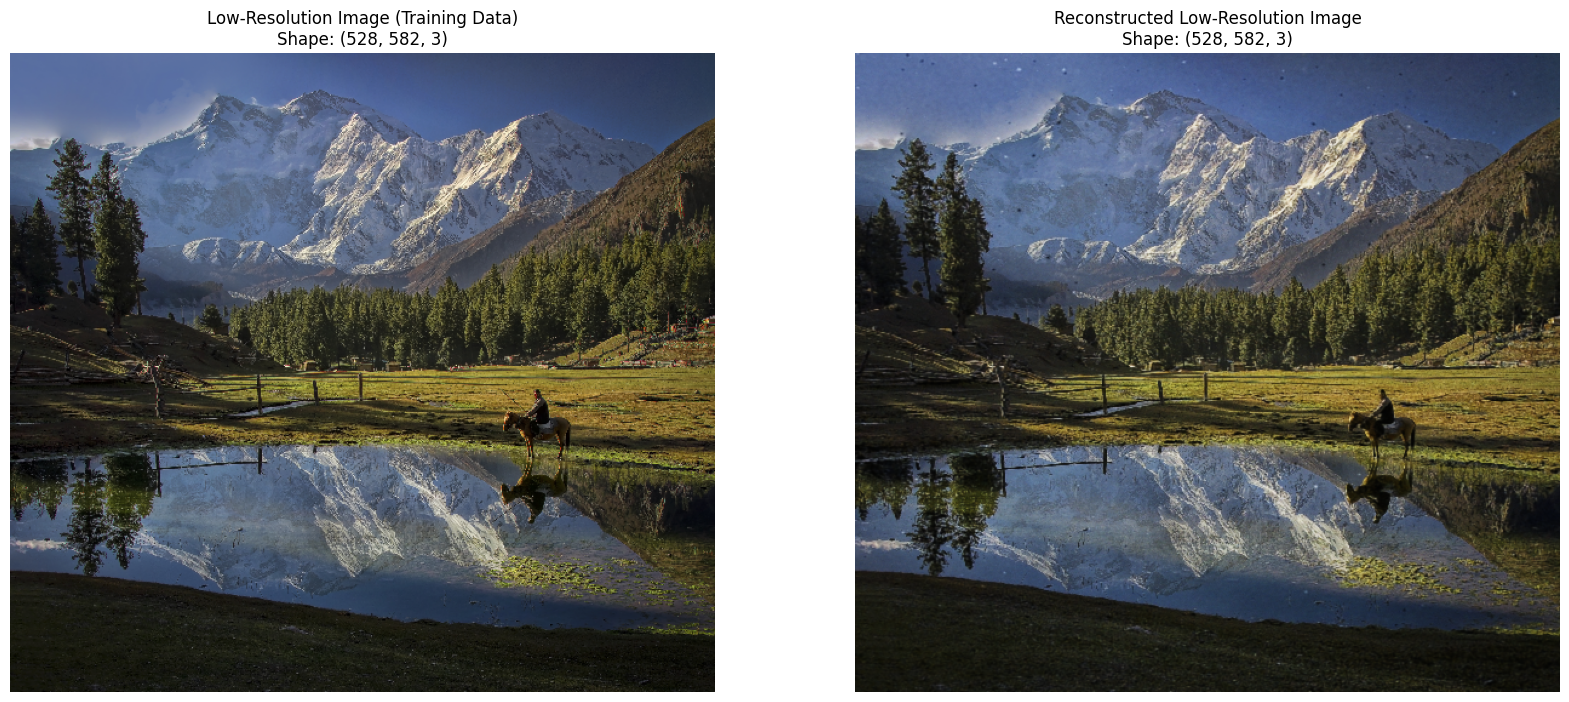

In [13]:
# Reconstruct the low-resolution image (learned during training)
target_coords_tensor_lr = torch.from_numpy(low_res_coords).float().to(device)
with torch.no_grad():
    pred_pixels_lr = model(target_coords_tensor_lr).cpu().numpy()

# Reshape and denormalize the predicted pixels for the low-resolution image
reconstructed_img_lr_normalized = pred_pixels_lr.reshape(low_res_shape[0], low_res_shape[1], 3)

# reconstructed_img_lr_denormalized = (reconstructed_img_lr_normalized * 255).astype(np.uint8)
# reconstructed_img_lr_denormalized = np.clip(reconstructed_img_lr_denormalized, 0, 255)

# Plot the reconstructed low-resolution image side by side with the training low res image
plt.figure(figsize=(20, 15))
plt.subplot(1, 2, 1)
plt.imshow(low_res_image)
plt.title(f"Low-Resolution Image (Training Data)\nShape: {low_res_image.shape}")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img_lr_normalized)
plt.title(f"Reconstructed Low-Resolution Image\nShape: {reconstructed_img_lr_normalized.shape}")
plt.axis("off")
plt.show()

In [14]:
def cross_validate_baby_sine(
    coordinates, 
    pixel_values, 
    batch_size=4096, 
    param_grid=None, 
    device=None
):
    """
    Perform cross-validation to find the best hyperparameters for BabySINE based on training loss.
    
    Args:
        coordinates (np.ndarray): Input coordinates (low-resolution).
        pixel_values (np.ndarray): Target pixel values (low-resolution).
        batch_size (int): Batch size for training.
        param_grid (dict): Dictionary of hyperparameters to search.
        device (torch.device): Device to use for training (CPU, CUDA, or MPS).
    
    Returns:
        dict: Best hyperparameters and their corresponding training loss.
    """
    if device is None:
        device = torch.device(
            "mps" if torch.backends.mps.is_available() else
            "cuda" if torch.cuda.is_available() else
            "cpu"
        )
    print(f"Using device: {device}")
    
    # Create dataset and dataloader
    dataset = ImageDataset(coordinates, pixel_values)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Default parameter grid if none is provided
    if param_grid is None:
        param_grid = {
            "hidden_dim": [256, 512],
            "num_layers": [4, 5],
            "lr": [1e-4, 5e-4, 1e-3],
            "num_epochs": [50, 100, 200],
        }
    
    # Generate all combinations of hyperparameters
    param_combinations = list(itertools.product(
        param_grid["hidden_dim"],
        param_grid["num_layers"],
        param_grid["lr"],
        param_grid["num_epochs"]
    ))
    
    best_params = None
    best_train_loss = float("inf")
    all_losses = []  # Store losses for all parameter combinations
    param_labels = []  # Store parameter labels for plotting
    
    # Iterate over all parameter combinations with tqdm
    for params in tqdm(param_combinations, desc="Hyperparameter Combinations"):
        hidden_dim, num_layers, lr, num_epochs = params
        print(f"Testing params: hidden_dim={hidden_dim}, num_layers={num_layers}, lr={lr}, num_epochs={num_epochs}")
        
        # Initialize the model
        model = BabySINE(
            input_dim=2,
            output_dim=3,
            hidden_dim=hidden_dim,
            num_layers=num_layers
        ).to(device)
        
        # Train the model using the existing train_model function
        losses, _ = model.train_model(
            dataloader=dataloader,
            num_epochs=num_epochs,
            lr=lr,
            device=device,
            criterion=torch.nn.L1Loss(),
            sigma=10.0,
            scheduler_step_size=50,
            scheduler_gamma=0.5
        )
        
        # Get the final training loss
        final_train_loss = losses[-1]
        print(f"Final Training Loss: {final_train_loss:.6f}")
        
        # Store losses and parameter labels for plotting
        all_losses.append(losses)
        param_labels.append(f"hd={hidden_dim}, nl={num_layers}, lr={lr}, ep={num_epochs}")
        
        # Update best parameters if training loss improves
        if final_train_loss < best_train_loss:
            best_train_loss = final_train_loss
            best_params = {
                "hidden_dim": hidden_dim,
                "num_layers": num_layers,
                "lr": lr,
                "num_epochs": num_epochs,
                "train_loss": final_train_loss
            }
    
    # Plot the training losses for all parameter combinations
    plt.figure(figsize=(12, 8))
    for i, losses in enumerate(all_losses):
        plt.plot(losses, label=param_labels[i])
    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.title("Training Loss for Different Hyperparameter Combinations")
    plt.legend(loc="upper right", fontsize="small")
    plt.grid(True)
    plt.show()
    
    print(f"Best Parameters: {best_params}")
    return best_params

The original image has shape: (1848, 2040, 3)
The downsampled image has shape: (231, 255, 3)
Using device: mps


Hyperparameter Combinations:   0%|          | 0/36 [00:00<?, ?it/s]

Testing params: hidden_dim=256, num_layers=4, lr=0.0001, num_epochs=50
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.235060
Epoch 0: Predicted pixel values range: 0.40629875659942627, 0.5998407602310181


Hyperparameter Combinations:   3%|▎         | 1/36 [00:10<06:09, 10.55s/it]

Learning rate: 5e-05
Final Training Loss: 0.021912
Testing params: hidden_dim=256, num_layers=4, lr=0.0001, num_epochs=100
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.235353
Epoch 0: Predicted pixel values range: 0.40958935022354126, 0.5835795998573303


Learning rate: 5e-05


Hyperparameter Combinations:   6%|▌         | 2/36 [00:32<09:38, 17.02s/it]

Learning rate: 2.5e-05
Final Training Loss: 0.012775
Testing params: hidden_dim=256, num_layers=4, lr=0.0001, num_epochs=200
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.235917
Epoch 0: Predicted pixel values range: 0.4057815968990326, 0.5826330184936523


Learning rate: 5e-05


Learning rate: 2.5e-05


Epoch 100, Loss: 0.012563
Epoch 100: Predicted pixel values range: 0.018864620476961136, 0.894097626209259


Learning rate: 1.25e-05


Hyperparameter Combinations:   8%|▊         | 3/36 [01:13<15:35, 28.34s/it]

Learning rate: 6.25e-06
Final Training Loss: 0.008004
Testing params: hidden_dim=256, num_layers=4, lr=0.0005, num_epochs=50
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.195960
Epoch 0: Predicted pixel values range: 0.17874541878700256, 0.6815256476402283


Hyperparameter Combinations:  11%|█         | 4/36 [01:24<11:18, 21.19s/it]

Learning rate: 0.00025
Final Training Loss: 0.039198
Testing params: hidden_dim=256, num_layers=4, lr=0.0005, num_epochs=100
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.190827
Epoch 0: Predicted pixel values range: 0.17358611524105072, 0.6963924765586853


Learning rate: 0.00025


Hyperparameter Combinations:  14%|█▍        | 5/36 [01:45<10:55, 21.15s/it]

Learning rate: 0.000125
Final Training Loss: 0.020565
Testing params: hidden_dim=256, num_layers=4, lr=0.0005, num_epochs=200
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.194611
Epoch 0: Predicted pixel values range: 0.18063759803771973, 0.7549459338188171


Learning rate: 0.00025


Learning rate: 0.000125
Epoch 100, Loss: 0.018298
Epoch 100: Predicted pixel values range: 0.0354398638010025, 0.8768961429595947


Learning rate: 6.25e-05


Hyperparameter Combinations:  17%|█▋        | 6/36 [02:27<14:13, 28.44s/it]

Learning rate: 3.125e-05
Final Training Loss: 0.008234
Testing params: hidden_dim=256, num_layers=4, lr=0.001, num_epochs=50
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.183073
Epoch 0: Predicted pixel values range: 0.15423128008842468, 0.7113090753555298


Hyperparameter Combinations:  19%|█▉        | 7/36 [02:38<10:54, 22.57s/it]

Learning rate: 0.0005
Final Training Loss: 0.070754
Testing params: hidden_dim=256, num_layers=4, lr=0.001, num_epochs=100
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.183553
Epoch 0: Predicted pixel values range: 0.15124724805355072, 0.7107798457145691


Learning rate: 0.0005


Hyperparameter Combinations:  22%|██▏       | 8/36 [02:59<10:19, 22.11s/it]

Learning rate: 0.00025
Final Training Loss: 0.038454
Testing params: hidden_dim=256, num_layers=4, lr=0.001, num_epochs=200
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.183653
Epoch 0: Predicted pixel values range: 0.16905342042446136, 0.653864860534668


Learning rate: 0.0005


Learning rate: 0.00025
Epoch 100, Loss: 0.036719
Epoch 100: Predicted pixel values range: 0.04623410478234291, 0.8077501654624939


Learning rate: 0.000125


Hyperparameter Combinations:  25%|██▌       | 9/36 [03:42<12:53, 28.63s/it]

Learning rate: 6.25e-05
Final Training Loss: 0.013516
Testing params: hidden_dim=256, num_layers=5, lr=0.0001, num_epochs=50
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.229721
Epoch 0: Predicted pixel values range: 0.3730422258377075, 0.6100119948387146


Hyperparameter Combinations:  28%|██▊       | 10/36 [03:53<10:01, 23.14s/it]

Learning rate: 5e-05
Final Training Loss: 0.020723
Testing params: hidden_dim=256, num_layers=5, lr=0.0001, num_epochs=100
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.229227
Epoch 0: Predicted pixel values range: 0.3721052408218384, 0.6160570979118347


Learning rate: 5e-05


Hyperparameter Combinations:  31%|███       | 11/36 [04:15<09:35, 23.01s/it]

Learning rate: 2.5e-05
Final Training Loss: 0.011175
Testing params: hidden_dim=256, num_layers=5, lr=0.0001, num_epochs=200
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.229902
Epoch 0: Predicted pixel values range: 0.3710927367210388, 0.6212241053581238


Learning rate: 5e-05


Learning rate: 2.5e-05


Epoch 100, Loss: 0.010635
Epoch 100: Predicted pixel values range: 0.03333645686507225, 0.8937408924102783


Learning rate: 1.25e-05


Hyperparameter Combinations:  33%|███▎      | 12/36 [04:59<11:41, 29.24s/it]

Learning rate: 6.25e-06
Final Training Loss: 0.005548
Testing params: hidden_dim=256, num_layers=5, lr=0.0005, num_epochs=50
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.187516
Epoch 0: Predicted pixel values range: 0.19858130812644958, 0.5313222408294678


Hyperparameter Combinations:  36%|███▌      | 13/36 [05:10<09:04, 23.66s/it]

Learning rate: 0.00025
Final Training Loss: 0.043720
Testing params: hidden_dim=256, num_layers=5, lr=0.0005, num_epochs=100
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.184872
Epoch 0: Predicted pixel values range: 0.19304920732975006, 0.5592887997627258


Learning rate: 0.00025


Hyperparameter Combinations:  39%|███▉      | 14/36 [05:32<08:28, 23.11s/it]

Learning rate: 0.000125
Final Training Loss: 0.018716
Testing params: hidden_dim=256, num_layers=5, lr=0.0005, num_epochs=200
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.185854
Epoch 0: Predicted pixel values range: 0.18610650300979614, 0.6356498003005981


Learning rate: 0.00025


Learning rate: 0.000125
Epoch 100, Loss: 0.017675
Epoch 100: Predicted pixel values range: 0.04341408237814903, 0.8843227624893188


Learning rate: 6.25e-05


Hyperparameter Combinations:  42%|████▏     | 15/36 [06:15<10:15, 29.29s/it]

Learning rate: 3.125e-05
Final Training Loss: 0.006930
Testing params: hidden_dim=256, num_layers=5, lr=0.001, num_epochs=50
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.178667
Epoch 0: Predicted pixel values range: 0.14086554944515228, 0.7191413044929504


Hyperparameter Combinations:  44%|████▍     | 16/36 [06:26<07:55, 23.77s/it]

Learning rate: 0.0005
Final Training Loss: 0.150636
Testing params: hidden_dim=256, num_layers=5, lr=0.001, num_epochs=100
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.180384
Epoch 0: Predicted pixel values range: 0.144744873046875, 0.7431033849716187


Learning rate: 0.0005


Hyperparameter Combinations:  47%|████▋     | 17/36 [06:49<07:23, 23.36s/it]

Learning rate: 0.00025
Final Training Loss: 0.149349
Testing params: hidden_dim=256, num_layers=5, lr=0.001, num_epochs=200
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.179125
Epoch 0: Predicted pixel values range: 0.14596857130527496, 0.6792972683906555


Learning rate: 0.0005


Learning rate: 0.00025


Epoch 100, Loss: 0.149281
Epoch 100: Predicted pixel values range: 0.20653587579727173, 0.3468248248100281


Learning rate: 0.000125


Hyperparameter Combinations:  50%|█████     | 18/36 [07:33<08:53, 29.65s/it]

Learning rate: 6.25e-05
Final Training Loss: 0.148926
Testing params: hidden_dim=512, num_layers=4, lr=0.0001, num_epochs=50
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.233608
Epoch 0: Predicted pixel values range: 0.33137819170951843, 0.659298300743103


Hyperparameter Combinations:  53%|█████▎    | 19/36 [07:44<06:51, 24.19s/it]

Learning rate: 5e-05
Final Training Loss: 0.014408
Testing params: hidden_dim=512, num_layers=4, lr=0.0001, num_epochs=100
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.231080
Epoch 0: Predicted pixel values range: 0.3139895796775818, 0.6827259063720703


Learning rate: 5e-05


Hyperparameter Combinations:  56%|█████▌    | 20/36 [08:07<06:20, 23.77s/it]

Learning rate: 2.5e-05
Final Training Loss: 0.007537
Testing params: hidden_dim=512, num_layers=4, lr=0.0001, num_epochs=200
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.232467
Epoch 0: Predicted pixel values range: 0.3262520730495453, 0.6720708608627319


Learning rate: 5e-05


Learning rate: 2.5e-05


Epoch 100, Loss: 0.006880
Epoch 100: Predicted pixel values range: 0.024004198610782623, 0.9258975982666016


Learning rate: 1.25e-05


Hyperparameter Combinations:  58%|█████▊    | 21/36 [08:52<07:31, 30.12s/it]

Learning rate: 6.25e-06
Final Training Loss: 0.002236
Testing params: hidden_dim=512, num_layers=4, lr=0.0005, num_epochs=50
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.200126
Epoch 0: Predicted pixel values range: 0.11975730210542679, 0.81421959400177


Hyperparameter Combinations:  61%|██████    | 22/36 [09:03<05:41, 24.41s/it]

Learning rate: 0.00025
Final Training Loss: 0.042108
Testing params: hidden_dim=512, num_layers=4, lr=0.0005, num_epochs=100
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.190096
Epoch 0: Predicted pixel values range: 0.11968277394771576, 0.8194870352745056


Learning rate: 0.00025


Hyperparameter Combinations:  64%|██████▍   | 23/36 [09:26<05:10, 23.85s/it]

Learning rate: 0.000125
Final Training Loss: 0.015453
Testing params: hidden_dim=512, num_layers=4, lr=0.0005, num_epochs=200
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.201027
Epoch 0: Predicted pixel values range: 0.1305539757013321, 0.8179976940155029


Learning rate: 0.00025


Learning rate: 0.000125


Epoch 100, Loss: 0.014165
Epoch 100: Predicted pixel values range: 0.0418335497379303, 0.8728199601173401


Learning rate: 6.25e-05


Hyperparameter Combinations:  67%|██████▋   | 24/36 [10:11<06:04, 30.41s/it]

Learning rate: 3.125e-05
Final Training Loss: 0.004445
Testing params: hidden_dim=512, num_layers=4, lr=0.001, num_epochs=50
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.196860
Epoch 0: Predicted pixel values range: 0.12587471306324005, 0.7987472414970398


Hyperparameter Combinations:  69%|██████▉   | 25/36 [10:23<04:32, 24.73s/it]

Learning rate: 0.0005
Final Training Loss: 0.151485
Testing params: hidden_dim=512, num_layers=4, lr=0.001, num_epochs=100
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.199632
Epoch 0: Predicted pixel values range: 0.12994585931301117, 0.7975279092788696


Learning rate: 0.0005


Hyperparameter Combinations:  72%|███████▏  | 26/36 [10:46<04:02, 24.20s/it]

Learning rate: 0.00025
Final Training Loss: 0.149633
Testing params: hidden_dim=512, num_layers=4, lr=0.001, num_epochs=200
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.197006
Epoch 0: Predicted pixel values range: 0.12453316897153854, 0.8298496007919312


Learning rate: 0.0005


Learning rate: 0.00025


Epoch 100, Loss: 0.087526
Epoch 100: Predicted pixel values range: 0.05960701033473015, 0.6435873508453369


Learning rate: 0.000125


Hyperparameter Combinations:  75%|███████▌  | 27/36 [11:31<04:35, 30.59s/it]

Learning rate: 6.25e-05
Final Training Loss: 0.017202
Testing params: hidden_dim=512, num_layers=5, lr=0.0001, num_epochs=50
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.225163
Epoch 0: Predicted pixel values range: 0.261217325925827, 0.6821134090423584


Hyperparameter Combinations:  78%|███████▊  | 28/36 [11:43<03:19, 24.94s/it]

Learning rate: 5e-05
Final Training Loss: 0.015115
Testing params: hidden_dim=512, num_layers=5, lr=0.0001, num_epochs=100
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.224550
Epoch 0: Predicted pixel values range: 0.3115508556365967, 0.6752586960792542


Learning rate: 5e-05


Hyperparameter Combinations:  81%|████████  | 29/36 [12:07<02:52, 24.67s/it]

Learning rate: 2.5e-05
Final Training Loss: 0.008184
Testing params: hidden_dim=512, num_layers=5, lr=0.0001, num_epochs=200
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.224190
Epoch 0: Predicted pixel values range: 0.29764747619628906, 0.6914424896240234


Learning rate: 5e-05


Learning rate: 2.5e-05


Epoch 100, Loss: 0.006836
Epoch 100: Predicted pixel values range: 0.02787034399807453, 0.9311121106147766


Learning rate: 1.25e-05


Hyperparameter Combinations:  83%|████████▎ | 30/36 [12:56<03:10, 31.82s/it]

Learning rate: 6.25e-06
Final Training Loss: 0.002198
Testing params: hidden_dim=512, num_layers=5, lr=0.0005, num_epochs=50
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.192153
Epoch 0: Predicted pixel values range: 0.16383884847164154, 0.7368793487548828


Hyperparameter Combinations:  86%|████████▌ | 31/36 [13:08<02:09, 25.84s/it]

Learning rate: 0.00025
Final Training Loss: 0.104338
Testing params: hidden_dim=512, num_layers=5, lr=0.0005, num_epochs=100
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.193503
Epoch 0: Predicted pixel values range: 0.15033403038978577, 0.7652183771133423


Learning rate: 0.00025


Hyperparameter Combinations:  89%|████████▉ | 32/36 [13:31<01:40, 25.25s/it]

Learning rate: 0.000125
Final Training Loss: 0.053334
Testing params: hidden_dim=512, num_layers=5, lr=0.0005, num_epochs=200
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.185592
Epoch 0: Predicted pixel values range: 0.134608194231987, 0.8015621900558472


Learning rate: 0.00025


Learning rate: 0.000125


Epoch 100, Loss: 0.044754
Epoch 100: Predicted pixel values range: 0.060676347464323044, 0.7057539820671082


Learning rate: 6.25e-05


Hyperparameter Combinations:  92%|█████████▏| 33/36 [14:19<01:35, 31.98s/it]

Learning rate: 3.125e-05
Final Training Loss: 0.008927
Testing params: hidden_dim=512, num_layers=5, lr=0.001, num_epochs=50
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.209733
Epoch 0: Predicted pixel values range: 0.14725437760353088, 0.8195016980171204


Hyperparameter Combinations:  94%|█████████▍| 34/36 [14:31<00:51, 25.89s/it]

Learning rate: 0.0005
Final Training Loss: 0.152082
Testing params: hidden_dim=512, num_layers=5, lr=0.001, num_epochs=100
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.212035
Epoch 0: Predicted pixel values range: 0.15631337463855743, 0.8010817170143127


Learning rate: 0.0005


Hyperparameter Combinations:  97%|█████████▋| 35/36 [14:55<00:25, 25.37s/it]

Learning rate: 0.00025
Final Training Loss: 0.149783
Testing params: hidden_dim=512, num_layers=5, lr=0.001, num_epochs=200
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.216261
Epoch 0: Predicted pixel values range: 0.18337447941303253, 0.7770630717277527


Learning rate: 0.0005


Learning rate: 0.00025


Epoch 100, Loss: 0.149721
Epoch 100: Predicted pixel values range: 0.19197337329387665, 0.3790699541568756


Learning rate: 0.000125


Hyperparameter Combinations: 100%|██████████| 36/36 [15:43<00:00, 26.20s/it]

Learning rate: 6.25e-05
Final Training Loss: 0.149021


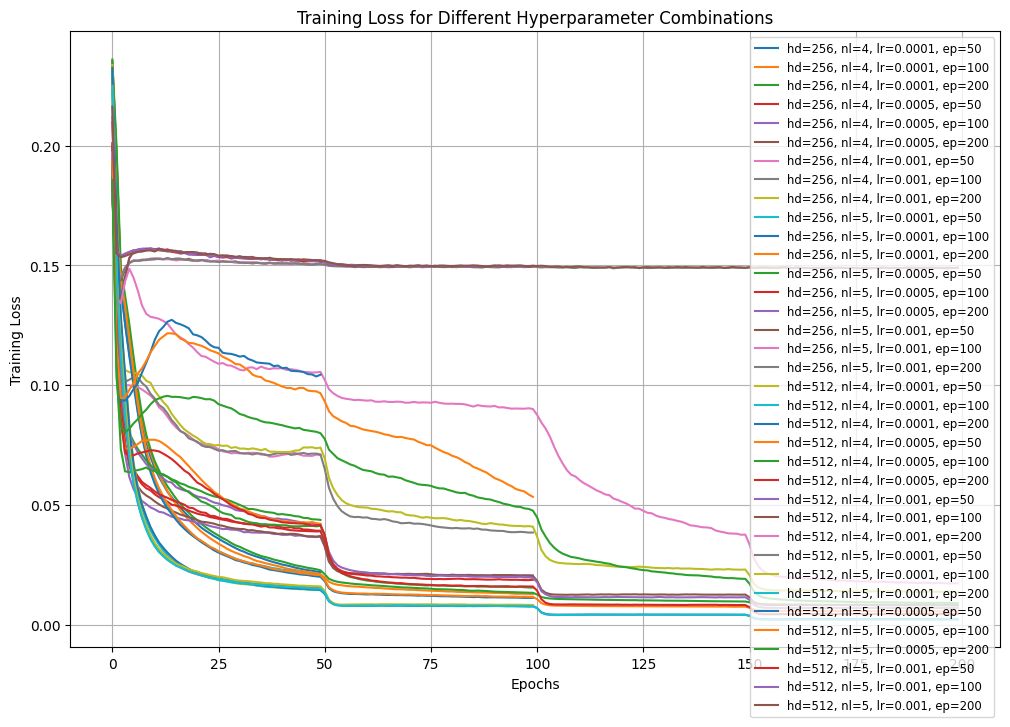

Best Parameters: {'hidden_dim': 512, 'num_layers': 5, 'lr': 0.0001, 'num_epochs': 200, 'train_loss': 0.002197828330099583}


In [15]:
# Generate low-resolution data
low_res_coords, low_res_pixel_values, _, _, _, _ = pixel_coordinates_normalized(img_np_original, downsize_factor=8)

# Perform cross-validation
best_params = cross_validate_baby_sine(
    coordinates=low_res_coords,
    pixel_values=low_res_pixel_values,
    batch_size=4096,
    param_grid=None
)